In [1]:
import os
from tqdm import tqdm
import cv2
import scipy as sp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans


'''
In idea to do the segmentation : After use k-means clustering on the whole image so as to differentiate the skin from the nevus.
This would divide the pixels into two clusters. Then I could use sinusoïdale fit with low order regression to get a segmentation of the nevus. 
'''




'\nIn idea to do the segmentation : After use k-means clustering on the whole image so as to differentiate the skin from the nevus.\nThis would divide the pixels into two clusters. Then I could use sinusoïdale fit with low order regression to get a segmentation of the nevus. \n'

In [4]:
def LoadandTreat_images(image_path, mask_path):
    image=cv2.imread(image_path,cv2.IMREAD_COLOR)
    #image=image[40:-40,30:-30]   #Image cropping

    ### Apply DullRazor Algorithme to remove hair
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )               # Gray scale
    kernel = cv2.getStructuringElement(1,(20,20)) # (9,9) initialy     # select kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) # Black hat filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)           # Gaussian filter
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)             # Binary thresholding (MASK)
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)                  # Replace pixels of the mask
    
    ### Apply Mask to the image
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

    try :
        image=cv2.bitwise_and(dst,dst,mask=mask)
    except:
        print(str(mask_path).split('/')[-1])
        print(mask.shape)  # Should print the same shape as 'dst'
        print(str(image_path).split('/')[-1])
        print(dst.shape)
        print(np.unique(mask))  # Should print only 0 and 255
    
    # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # permet de convertir l'image en RGB (openCV lie par défaut du BGR)
    return image


def create_nevus_mask(image, dark_threshold=30):
    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)

    # Perform k-means clustering with 3 colors
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(pixels)

    # Find the mean color of each cluster
    mean_colors = kmeans.cluster_centers_

    # Check if any of the mean colors is below the dark threshold
    dark_cluster = np.any(mean_colors < dark_threshold, axis=1)

    if np.any(dark_cluster):
        # If there is a dark cluster, remove it and perform k-means clustering with 2 colors
        non_dark_pixels = pixels[kmeans.labels_ != np.argmax(dark_cluster)]
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(non_dark_pixels)
    else:
        # If there is no dark cluster, perform k-means clustering with 2 colors on the whole image
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(pixels)

    # Assume the nevus is the least common color
    nevus_label = np.argmin(np.bincount(kmeans.labels_))

    # Create a binary mask for the nevus
    nevus_mask = (kmeans.labels_ == nevus_label).reshape(image.shape[:2])

    return nevus_mask




In [3]:
### Importing Dataset ###
train_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Train'
test_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Test'

train_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Mask'
test_mask_path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Test\Mask'

#pourcentage = 0.8
l_dir_test_complet = os.listdir(test_path)
l_dir_test_mask = os.listdir(test_mask_path)

l_dir_train_complet = os.listdir(train_path)
l_dir_train_mask = os.listdir(train_mask_path)

# region : Ces deux boucles for permettent de ne séléctionner que les images qui ont un mask correspondant
## Je n'arrive pas à faire de masks pour le moment donc je me contente de ceux qui étaient déjà fournis
l_dir_train = []
l_dir_test = []
i_train = 0
for file_name in tqdm(l_dir_train_mask):
    numero_mask  = file_name.split('_')[1]
    numero_train = (l_dir_train_complet[i_train].split('_')[1]).split('.')[0]
    while not numero_mask == numero_train:
        i_train += 1
        numero_train = (l_dir_train_complet[i_train].split('_')[1]).split('.')[0]
    l_dir_train.append(l_dir_train_complet[i_train])

i_test = 0
for file_name in tqdm(l_dir_test_mask):
    numero_mask  = file_name.split('_')[1]
    numero_test = (l_dir_test_complet[i_test].split('_')[1]).split('.')[0]
    while not numero_mask == numero_test:
        i_test += 1
        numero_test = (l_dir_test_complet[i_test].split('_')[1]).split('.')[0]
    l_dir_test.append(l_dir_test_complet[i_test])
# endregion


train_images_path = [os.path.join(train_path, fn) for fn in l_dir_train]
test_images_path = [os.path.join(test_path, fn) for fn in l_dir_test]

train_masks_paths = [os.path.join(train_mask_path, mask_name) for mask_name in l_dir_train_mask]
test_masks_paths = [os.path.join(test_mask_path, mask_name) for mask_name in l_dir_test_mask]

# These two lines return list of masked and hair removed images
test_images = [LoadandTreat_images(image_path, mask_path) for image_path, mask_path in tqdm(zip(test_images_path, test_masks_paths))]
train_images = [LoadandTreat_images(image_path, mask_path) for image_path, mask_path in tqdm(zip(train_images_path, train_masks_paths))]




100%|██████████| 648/648 [00:00<?, ?it/s]
648it [01:47,  6.01it/s]
1945it [05:25,  5.97it/s]


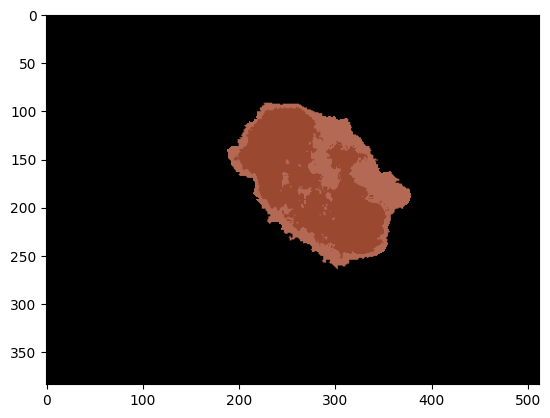

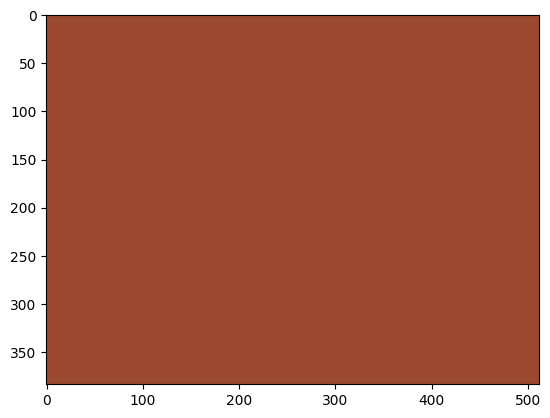

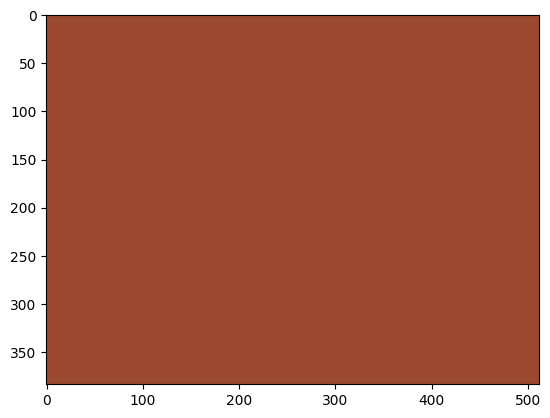

[[  0   0   0]
 [180 105  84]
 [155  72  48]]
[0. 0. 1.]
196608


In [14]:
'''
C : Colors
D : Dimension of the lesion
A : Asymmetry
B : Border Irregularity
'''
# Exemple avec plusieurs couleurs sur l'image ISIC_000060.jpg, indice 14 je crois bien
def colors(image):
    mean = np.mean(image, axis=(0, 1))
    std = np.std(image, axis=(0, 1))
    print(mean)
    print(std)



def ABCD(image, n_colors, max_hole_size=100):
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)

    # Perform k-means clustering to find the most dominant colors
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)

    # Replace each pixel with its nearest color
    segmented_image = kmeans.cluster_centers_[kmeans.labels_]
    segmented_image = segmented_image.reshape(image.shape).astype(np.uint8)

    # Compute the mean color of each cluster
    mean_colors = kmeans.cluster_centers_.astype(np.uint8)

    plt.imshow(segmented_image)
    plt.show()
    # Create a binary image for each color area and fill holes in it
    filled_labels = np.zeros_like(kmeans.labels_)
    for i in range(n_colors):
        binary_image = (kmeans.labels_ == i).reshape(image.shape[:2])
        plt.imshow(binary_image)
        plt.show()
        filled_image = sp.ndimage.binary_fill_holes(binary_image).astype(int)
        plt.imshow(filled_image)
        plt.show()
   
        # Identify holes and compute their sizes
        hole_labels, num_holes = sp.ndimage.label(~filled_image)
        hole_sizes = sp.ndimage.sum(~filled_image, hole_labels, range(1, num_holes+1))

        # Only fill holes that are below the maximum size
        for j in range(1, num_holes+1):
            if hole_sizes[j-1] <= max_hole_size:
                filled_image[hole_labels == j] = 1

        # Replace the original area with the filled area
        segmented_image[filled_image == 1] = mean_colors[i]
        # Update the filled labels
        filled_labels[filled_image.flatten() == 1] = i


    plt.imshow(segmented_image)
    plt.show()


    total_area = len(pixels)
    # Count the number of pixels in each filled cluster
    pixel_counts = np.bincount(filled_labels)

    # Compute the surface percentage of each filled cluster
    surface_percentages = pixel_counts / total_area

    return segmented_image, mean_colors, surface_percentages, total_area





image = test_images[36]
segmented_image, mean_colors,pourcentages, S = ABCD(image, 3)

plt.imshow(segmented_image)
plt.show()
print(mean_colors)
print(pourcentages)
print(S)
# colors(image)

Je vais essayer de faire un CNN qui segmente les nevus

In [ ]:
# Segmentation et pourquoi pas utiliser un réseau de neurone pour segmenter les images ?, en utilisant les images déjà segmentées comme données d'entrainement
segmenteur_CNN = Sequential()

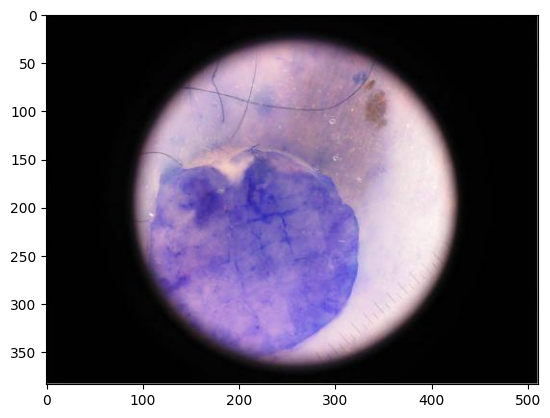

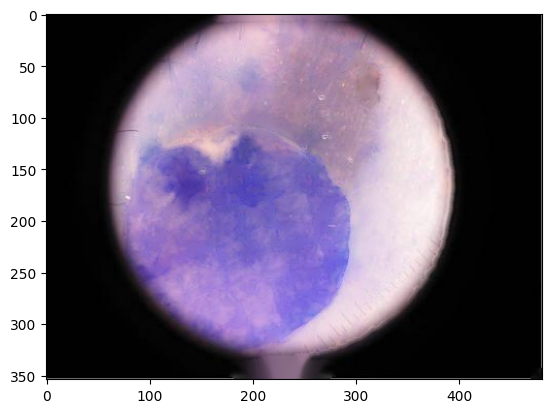

In [7]:
######### retirer les poils #########

#Input image
path = r'C:\Users\pc1\Leviia\Documents\2_ENS-Paris-Saclay\3A__M2_BME2_IPP\S2\IMA205 - Machine Learning\Defis_kaggle\Train\Train\ISIC_0000004.jpg'
#Read image
image=cv2.imread(path,cv2.IMREAD_COLOR)

#Image cropping
img=image[30:410,30:560]

#DULL RAZOR (REMOVE HAIR)

#Gray scale
grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
#Black hat filter
kernel = cv2.getStructuringElement(1,(20,20)) # = 9 basicaly
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
#Gaussian filter
bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
#Binary thresholding (MASK)
ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
#Replace pixels of the mask
dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)


#Display images
plt.imshow(image)
plt.show()
plt.imshow(dst)
plt.show()
    
